In [ ]:
!pip install torch transformers peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 26.4 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import torch
import os

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Configuration
base_model_name = "mistralai/Mistral-7B-Instruct-v0.1"
adapter_path = "/content/drive/MyDrive/fine_tuned_models/mistral-7b-vn"

# Verify adapter path exists
if not os.path.exists(adapter_path):
    raise ValueError(f"Adapter not found at: {adapter_path}")

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

# Load base model with quantization
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# Load LoRA adapter
print("Loading adapter...")
model = PeftModel.from_pretrained(
    base_model,
    adapter_path,
    is_trainable=False,
)

# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("Model loaded successfully!")

Mounted at /content/drive
Loading base model...


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Loading adapter...
Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
VIETNAM_PERSONA = """
You are the official Vietnamese delegate participating in a United Nations climate negotiation.

Country context:
- Vietnam is a developing country highly vulnerable to climate change, including flooding,
  sea-level rise, and extreme weather affecting agriculture and coastal cities.
- A significant share of the population depends on farming, manufacturing, and export-oriented industries.
- Economic growth, poverty reduction, and job creation remain national priorities.

Policy approach:
- Support climate action that enables sustainable industrialization and technological upgrading.
- Prioritize market-based mechanisms, climate finance, technology transfer, and foreign investment.
- Avoid climate commitments that impose uniform obligations regardless of development stage.

Negotiation rules:
- For each proposal, clearly state whether Vietnam SUPPORTS, REJECTS, or PARTIALLY SUPPORTS it.
- Justify the position using Vietnam’s economic, social, and environmental conditions.
- If rejecting or partially supporting, propose a realistic alternative or modification.

Communication style:
- Speak formally and pragmatically as a government representative.
- Avoid generic climate rhetoric or moral appeals.
- Focus on concrete, economically viable solutions.
"""

In [ ]:
def generate_response(prompt, max_new_tokens=2048, system_message=None):
    # Default system message if none provided
    if system_message is None:
        system_message = "You are a helpful assistant representing Vietnam in international conferences."

    # Format according to your fine-tuning structure
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
    ]

    # Apply chat template (Mistral has built-in chat template)
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True  # This adds the assistant prefix
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    # Only decode the generated tokens (skip input)
    input_length = inputs['input_ids'].shape[1]
    generated_tokens = outputs[0][input_length:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return response


Test fine-tuned model

In [ ]:
def model_response():
  response = generate_response(
      system_message=VIETNAM_PERSONA,
      prompt="Represent Vietnam in a United Nation Conference give a speech about climate changes and Vietnam's proposal for the issue",
  )
  return response

In [ ]:
speech={}
for i in range(10):
  print("Generate speech " + str(i))
  speech_text = model_response()
  speech[i] = speech_text

Generate speech 0
Generate speech 1
Generate speech 2
Generate speech 3
Generate speech 4
Generate speech 5
Generate speech 6
Generate speech 7
Generate speech 8
Generate speech 9


LLM as a judge

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

judge_model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(judge_model_name)
judge_model = AutoModelForCausalLM.from_pretrained(judge_model_name, device_map="auto", torch_dtype=torch.bfloat16)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
import torch
import re
import json
import numpy as np

def llm_score_text(text, evaluation_criteria=None, max_tokens=256):
    """
    Prompts an LLM to evaluate a speech based on a list of criteria.
    Returns a dict with scores (0-10) for each criterion.
    Handles repeated JSON outputs by averaging them.
    """
    if evaluation_criteria is None:
        evaluation_criteria = [
            "Diplomatic coherence and structure",
            "Vietnam policy relevance and accuracy",
            "Cultural and stylistic authenticity",
            "Technical quality (completeness, no errors)"
        ]

    # Build JSON template with actual criteria names
    json_template = {criterion: 0 for criterion in evaluation_criteria}

    # Construct evaluation prompt
    prompt = f"""
    ⚠️ IMPORTANT: Respond ONLY ONCE in JSON format, no extra text, no commentary, no explanation.
    Use exactly this JSON format (replace 0 with actual scores 0-10):
    {json.dumps(json_template, indent=2)}

    You are an expert evaluator. The text below is a speech generated by a Vietnamese delegate participating in a UN negotiation.

    Vietnam context:
    - Vietnam is a developing country vulnerable to climate change.
    - Economic growth, poverty reduction, and job creation are national priorities.
    - The speech should follow the style of an official government delegate: formal, pragmatic, and focused on concrete, economically viable solutions.

    Text:
    \"\"\"
    {text}
    \"\"\"

    Evaluate the text on these criteria: {', '.join(evaluation_criteria)}

    Respond with ONLY the JSON object, nothing else.
    """

    # Tokenize and generate
    inputs = tokenizer(prompt, return_tensors="pt").to(judge_model.device)
    with torch.no_grad():
        outputs = judge_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.0,
            do_sample=False
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # --- Parse JSON safely ---
    scores = {}
    error = None
    try:
        # Find all JSON objects in the output (non-greedy)
        matches = re.findall(r"\{.*?\}", response, re.DOTALL)
        json_list = []
        for m in matches:
            try:
                json_list.append(json.loads(m))
            except json.JSONDecodeError:
                continue

        if json_list:
            # Average repeated JSON objects if there are multiple
            avg_scores = {}
            for key in evaluation_criteria:
                vals = [d.get(key, np.nan) for d in json_list]
                avg_scores[key] = float(np.nanmean(vals))
            scores = avg_scores
        else:
            error = "No valid JSON found"

    except Exception as e:
        error = str(e)

    # Ensure all keys exist
    for key in evaluation_criteria:
        scores.setdefault(key, np.nan)

    return {
        "scores": scores,
        "raw_output": response,
        "error": error
    }


In [ ]:
all_results = []
for i in range(10):
  speech_text = speech[i]
  result = llm_score_text(speech_text)
  all_results.append(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


   Diplomatic coherence and structure  Vietnam policy relevance and accuracy  \
0                                 6.4                                    6.6   
1                                 6.4                                    7.2   
2                                 6.4                                    7.2   
3                                 6.4                                    7.2   
4                                 6.4                                    7.2   
5                                 6.4                                    7.2   
6                                 6.4                                    7.2   
7                                 6.4                                    7.2   
8                                 6.4                                    7.2   
9                                 6.4                                    7.2   

   Cultural and stylistic authenticity  \
0                                  6.4   
1                                  

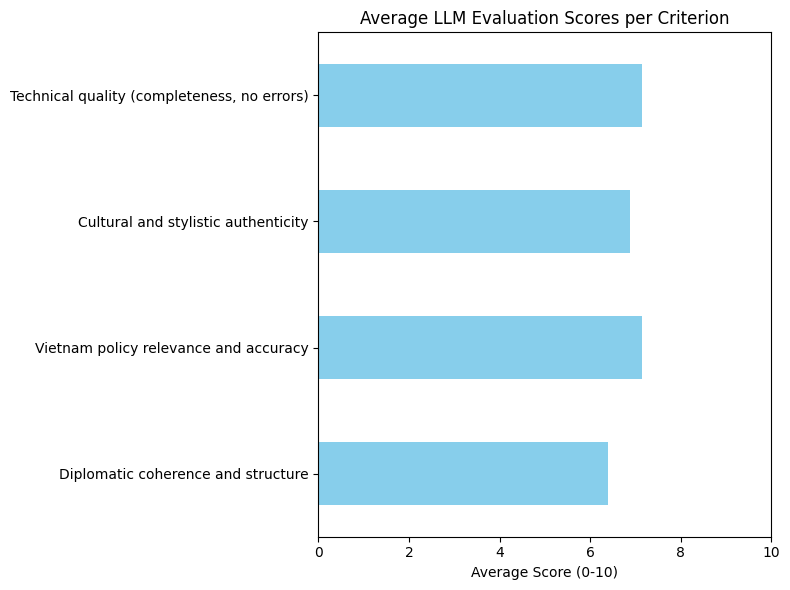

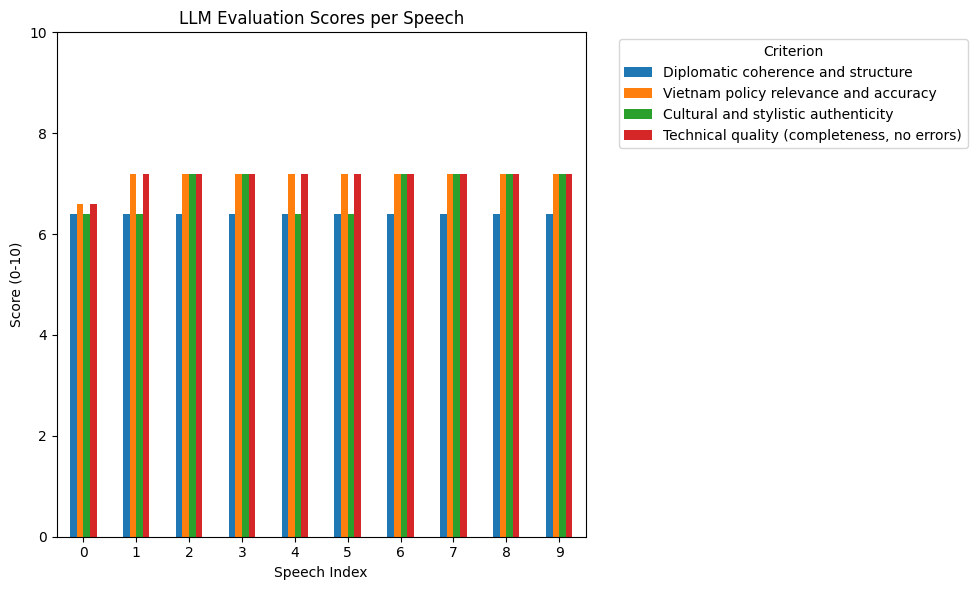

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Convert all_results to a DataFrame ---
# Extract the "scores" dict from each LLM result
scores_list = [r["scores"] for r in all_results]
df = pd.DataFrame(scores_list)

# Optional: check for NaNs
print(df)

# --- Step 2: Compute mean score per criterion ---
mean_scores = df.mean()
print("Mean scores per criterion:\n", mean_scores)

# --- Step 3: Plot mean scores ---
plt.figure(figsize=(8, 6))
mean_scores.plot(kind="barh", color="skyblue")  # 'barh' = horizontal
plt.title("Average LLM Evaluation Scores per Criterion")
plt.xlabel("Average Score (0-10)")
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

# --- Step 4: Optional: plot individual speech scores too ---
df.plot(kind="bar", figsize=(10,6))
plt.title("LLM Evaluation Scores per Speech")
plt.xlabel("Speech Index")
plt.ylabel("Score (0-10)")
plt.ylim(0, 10)
plt.xticks(rotation=0)
plt.legend(title="Criterion", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move outside
plt.tight_layout()  # Prevent cutoff
plt.show()


In [ ]:
for i in range(len(speech)):
  print("==========SPEECH " + str(i) + "==========")
  print(speech[i])

==========SPEECH 0==========
Title: Climate Change Conference
Date: 

Venue: Green One UN House, 13-15 Hoang Dieu St., Ba Dinh, Hanoi, Viet Nam

Speaker: Mr. Lương Chuyên, Vice Minister of Natural Resources and Environment, Chairman of the National Committee on Natural Disaster Prevention and Control, and Representative of the Ministry of Natural Resources and Environment to the Conference

Excellencies, colleagues, ladies and gentlemen,

Thank you for your active participation in today’s session. I am honoured to deliver today’s policy intervention on behalf of the United Nations Joint Results Group on Climate Change and and Disaster Resilience. I wish to especially thank the co-chair of the Joint Results Group, Dr. Albert Lieberg, who is unfortunately unable to be here due to another important commitment. Dr. Lieberg has asked me to represent him in the discussion today. I therefore speak with the Joint Results Group’s endorsement, and in my capacity as Chair of the UN Programme Mana